# Predicting Academic Outcomes
The following python notebook describes the code involved in data pre-processing, training of linear regression model, evaluating performance, and concluding with coefficients and plot of predicted scores.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


# Data Processing
Through exploratory data analysis, we found the 8 features that had a higher correlation with Exam Score than the others:

*   Hours Studied
*   Attendance
*   Parental Involvement
*   Access to Resources
*   Previous Scores
*   Learning Disability
*   Distance from Home
*   Tutoring Sessions

We then narrowed down the dataset to these main features.

There were only a total of 67 NaN values, so we could simply drop these data points instead of having to use imputation.

Finally, we had to convert our categorical variables to have numeric values for linear regression.

After these data processing steps, our dataset was ready for regression, so we split the dataset into 80% train, 10% validation, 10% test. We arrived at these splits because we had no problems with overfitting in any iteration of this model.

In [2]:
# Data Cleaning attempts (Missingness and Imputation)
data = pd.read_csv("/content/StudentPerformanceFactors.csv")

# Clean the CSV to only use the features we plan to analyze, as well as the response variable

main_features = ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement', 'Learning_Disabilities', 'Access_to_Resources', 'Distance_from_Home', 'Tutoring_Sessions', 'Exam_Score']

data = data[main_features]

# Searched data for missing values and confirmed all cells were complete
print("columns and how many null values")
print(data.isnull().sum())

# Check for any negative values
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['number'])

# Check for negative values in each numeric column
print("numeric columns", numeric_cols.columns)
negative_counts = (numeric_cols < 0).sum()

# Display columns with negative values
print("Count of Negative Values in Each Numeric Column:")
print(len(negative_counts[negative_counts > 0]))  # Only show columns with negative values

# From the above we can see that Distance From Home has some invalid cells
null_distance_rows = data[data['Distance_from_Home'].isnull()]

# We can confirm that some rows are coming up with NAN

# Get all unique values in 'Distance_from_Home' column
unique_values = data['Distance_from_Home'].unique()

# Print the unique values
print(unique_values)

# Clean the dataset by removing these rows
# row removal makes the most sense since no alternative value makes sense in the context of distance from home
# Additionally, the number of rows removed (67) is insignificant as it is ~1% of our rows

data = data.dropna(subset=['Distance_from_Home'])

# Test again to confirm no NAN rows are left

print(data.isnull().sum())

# Convert categorical variables into numeric values
low_med_high = {
    'Low': 1,
    'Medium': 2,
    'High': 3
}

yes_no = {
    'Yes': 1,
    'No': 0
}

near_moderate_far = {
    'Near': 1,
    'Moderate': 2,
    'Far': 3
}

data['Parental_Involvement'] = data['Parental_Involvement'].map(low_med_high)
data['Access_to_Resources'] = data['Access_to_Resources'].map(low_med_high)
data['Learning_Disabilities'] = data['Learning_Disabilities'].map(yes_no)
data['Distance_from_Home'] = data['Distance_from_Home'].map(near_moderate_far)
print(data.shape)

# Split the dataset into train, validation, and test
train_and_validation_df, test_df = train_test_split(data, test_size=0.1, random_state=2)

train_df, validation_df = train_test_split(train_and_validation_df, test_size=1/9, random_state=112)
# x values will be all features, and y will be the response variable, Exam Score
x_train = train_df.drop('Exam_Score', axis=1)
y_train = train_df['Exam_Score']

x_val = validation_df.drop('Exam_Score', axis=1)
y_val = validation_df['Exam_Score']

x_test = test_df.drop('Exam_Score', axis=1)
y_test = test_df['Exam_Score']



columns and how many null values
Hours_Studied             0
Attendance                0
Previous_Scores           0
Parental_Involvement      0
Learning_Disabilities     0
Access_to_Resources       0
Distance_from_Home       67
Tutoring_Sessions         0
Exam_Score                0
dtype: int64
numeric columns Index(['Hours_Studied', 'Attendance', 'Previous_Scores', 'Tutoring_Sessions',
       'Exam_Score'],
      dtype='object')
Count of Negative Values in Each Numeric Column:
0
['Near' 'Moderate' 'Far' nan]
Hours_Studied            0
Attendance               0
Previous_Scores          0
Parental_Involvement     0
Learning_Disabilities    0
Access_to_Resources      0
Distance_from_Home       0
Tutoring_Sessions        0
Exam_Score               0
dtype: int64
(6540, 9)


# Linear Regression
At this stage, we trained our linear regression model on the training set and evaluated it on the validation set. The coefficients found by the model are about the same magnitude, so this confirms that we do not need to standardize the dataset.

In [7]:
# Create and train a linear regression model
model = LinearRegression()
model.fit(x_train, y_train)
# Evaluate the model on the validation set
y_pred = model.predict(x_val)

mse = mean_squared_error(y_val, y_pred)
mad = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
corr = np.corrcoef(y_val, y_pred)[0, 1]

coefficients = model.coef_
intercept = model.intercept_

print("Coefficients:", coefficients)
print("Intercept:", intercept)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Deviation: {mad}")
print(f"R-squared: {r2}")
print(f"Correlation: {corr}")

Coefficients: [ 0.29271248  0.1985873   0.04826455  1.00194689 -0.77454866  0.97798462
 -0.49059927  0.49216206]
Intercept: 37.8354519335643
Mean Squared Error: 4.969473150288048
Mean Absolute Deviation: 0.9269585992170106
R-squared: 0.6798258955816602
Correlation: 0.8249740498235297


# Cross Validation
After training and testing the model on the validation set, we performed k fold cross validation to ensure we are not overfitting the data. This is used to perform further evaluation without contaminating the testing dataset. The metrics of our cross validation testing maintain similar performance to the single validation set testing used above, giving us evidence that we are not overfitting our training data.

In [8]:
# Define the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=21)

# Perform cross-validation
mse_scores = cross_val_score(model, x_train, y_train, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(model, x_train, y_train, cv=kf, scoring='r2')
mad_scores = cross_val_score(model, x_train, y_train, cv=kf, scoring='neg_mean_absolute_error')

# Since cross_val_score gives negative values for MSE and MAD, we convert them back to positive
mse_scores = -mse_scores
mad_scores = -mad_scores

# Print the results
print("Mean MSE: ", np.mean(mse_scores))
print("Mean R^2: ", np.mean(r2_scores))
print("Mean MAD: ", np.mean(mad_scores))

Mean MSE:  5.297854759101582
Mean R^2:  0.6578206575841226
Mean MAD:  0.9642121873190612


# Evaluation Metrics
Below are the evaluation metrics for our linear regression model. All metrics show a very good model, especially MAE showing that our predictions are within 1 point of the actual score on average.

In [ ]:
y_pred = model.predict(x_test)
# Calculate metrics on test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
corr = np.corrcoef(y_test, y_pred)[0, 1]
mae = mean_absolute_error(y_test, y_pred)
rMSE = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rMSE}")
print(f"R-squared: {r2}")
print(f"Correlation: {corr}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 3.0407820007661672
Root Mean Squared Error: 1.7437838170960778
R-squared: 0.7542948881539701
Correlation: 0.869012941647217
Mean Absolute Error: 0.8833794580784933


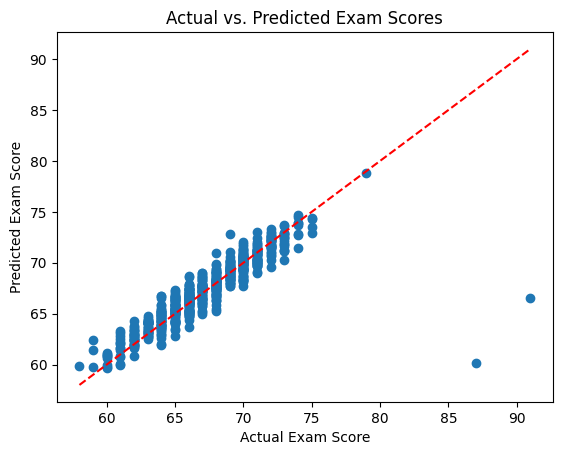

In [ ]:
# Visualize the model with a scatterplot

plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Exam Score")
plt.ylabel("Predicted Exam Score")
plt.title("Actual vs. Predicted Exam Scores")
plt.show()

Here is a scatterplot of our predicted values vs. the actual exam scores.

# Final Model & Conclusion
Show the coefficients multiplied by each feature to create the closed form that can be used for predicting test scores.

The model used on the test set is on our normalized data, meaning we can now use the coefficient magnitude to analyze feature importance. A sorted list of each feature and its coefficient is described below.

This allows us to conclude the significance of attendance and hours_studied in predicting exam score, as they positively impact the predicted exam score at a magnitude much greater than the other features.

In [ ]:
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.transform(x_test)
model.fit(x_train_normalized, y_train)
y_pred = model.predict(x_test_normalized)

coefficients = model.coef_

# Create a DataFrame with feature names and their corresponding coefficients
coeff_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Coefficient': coefficients
})

# Sort by absolute coefficient values
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
coeff_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print the coefficients and feature names
print(coeff_df[['Feature', 'Coefficient']])
print("Intercept: ", model.intercept_)

                 Feature  Coefficient
1             Attendance     2.284973
0          Hours_Studied     1.759526
3   Parental_Involvement     0.696758
2        Previous_Scores     0.695144
5    Access_to_Resources     0.683066
7      Tutoring_Sessions     0.607287
6     Distance_from_Home    -0.331265
4  Learning_Disabilities    -0.239832
Intercept:  67.23241590214067
